In [39]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [15]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',500)

The Shannon entropy can measure the uncertainty of a random process.It is the average rate at which information is produced by a stochastic source of data. The higher the Shannon entropy, the bigger the information is given by a new value in the process. 
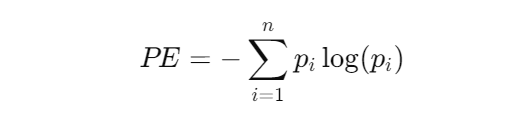

Complexity measure is a measure derived from permutation entropy. It quantifies the complexity of a time series by considering the number of possible permutations relative to the observed permutations.
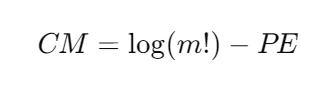

In [16]:
# Defining functions

# Shannon entropy (or just entropy) is a measure of uncertainty (or variability) associated with random variables.
def s_entropy(freq_list):
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 

def ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))
    

def p_entropy(op):
    
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

#### 1. Importing Accelerometer Data

In [17]:
# Importing the accelerometer dataset

df_acc = pd.read_csv('accelerometer.csv')
df_acc['time'] = df_acc['time'].apply(str).str[:10].apply(int)
df_acc['time'] = pd.to_datetime(df_acc['time'],unit='s')
df_acc.head(20)

# df_acc['time'] = [x[:8] for x in df_acc['time']]
# df_acc = pd.read_csv('Data/accelerometer.csv')[lambda x: x['pid'] == 'SA0297'].sort_values(by='time')

,time,pid,x,y,z
0,1970-01-01 00:00:00,JB3156,0.0000,0.0000,0.0000
1,1970-01-01 00:00:00,CC6740,0.0000,0.0000,0.0000
2,2017-05-02 14:04:42,SA0297,0.0758,0.0273,-0.0102
3,2017-05-02 14:04:42,SA0297,-0.0359,0.0794,0.0037
4,2017-05-02 14:04:42,SA0297,-0.2427,-0.0861,-0.0163
5,2017-05-02 14:04:43,SA0297,-0.2888,0.0514,-0.0145
6,2017-05-02 14:04:43,SA0297,-0.0413,-0.0184,-0.0105
7,2017-05-02 14:04:43,SA0297,-0.0413,-0.0001,0.0017
8,2017-05-02 14:04:43,SA0297,-0.0286,-0.0028,-0.0094
9,2017-05-02 14:04:43,SA0297,-0.0543,-0.0410,-0.0109


In [18]:
df_acc.shape

(1048575, 5)

#### 2. Importing TAC Readings

In [19]:
# creating a list of all TAC_Readings

pid_list = ['BK7610','BU4707','CC6740','DC6359','DK3500','HV0618','JB3156','JR8022','MC7070','MJ8002','PC6771','SA0297','SF3079']

In [21]:
# creating a dataframe from TAC_Readings

df_tac = pd.DataFrame()

for pid in pid_list:
    temp = pd.read_csv('{0}.csv'.format(pid))
    temp['timestamp'] = pd.to_datetime(temp['timestamp'],unit='s')
    temp.rename(columns = {'timestamp':'time'}, inplace = True)
    temp['pid'] = pid
    df_tac = pd.concat([df_tac,temp])
    

df_tac.head(20)

,time,TAC_Reading,pid
0,2017-05-02 09:51:54,-0.000482,BK7610
1,2017-05-02 10:24:57,0.001573,BK7610
2,2017-05-02 10:30:27,0.002144,BK7610
3,2017-05-02 10:35:57,0.000877,BK7610
4,2017-05-02 10:41:26,-0.001145,BK7610
5,2017-05-02 10:46:56,-0.002159,BK7610
6,2017-05-02 10:52:25,-0.001033,BK7610
7,2017-05-02 10:57:54,0.001808,BK7610
8,2017-05-02 11:03:23,0.004542,BK7610
9,2017-05-02 11:33:52,0.005185,BK7610


In [22]:
df_tac.shape

(715, 3)

#### 3. Merging Tables

In [23]:
# Merging the accelerometer dataframe and the TAC_Readings dataframe

df_all = df_acc.merge(df_tac, on = ['pid','time'])
df_all.head(100)

,time,pid,x,y,z,TAC_Reading
0,2017-05-02 14:14:08,SA0297,0.1312,0.0432,0.0034,0.032672
1,2017-05-02 14:14:08,SA0297,0.2734,0.1197,0.0968,0.032672
2,2017-05-02 14:14:08,SA0297,0.1514,0.1886,0.0375,0.032672
3,2017-05-02 14:14:08,SA0297,-0.0914,0.0496,0.0534,0.032672
4,2017-05-02 14:14:08,SA0297,-0.7935,-0.5184,0.3967,0.032672
5,2017-05-02 14:14:08,SA0297,-0.3427,0.2482,-0.0175,0.032672
6,2017-05-02 14:14:08,SA0297,-0.3718,0.2592,-0.3961,0.032672
7,2017-05-02 14:14:08,SA0297,-0.2288,0.0383,-0.5308,0.032672
8,2017-05-02 14:14:08,SA0297,-0.0053,-0.0141,-0.0991,0.032672
9,2017-05-02 14:14:08,SA0297,-0.1069,-0.2478,0.1142,0.032672


In [24]:
df_all.shape

(444, 6)

In [25]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         444 non-null    datetime64[ns]
 1   pid          444 non-null    object        
 2   x            444 non-null    float64       
 3   y            444 non-null    float64       
 4   z            444 non-null    float64       
 5   TAC_Reading  444 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 20.9+ KB


In [ ]:
# df_normalized = df_all.groupby(['time','pid']).agg('mean').reset_index()
# df_normalized

#### 4. Plotting Data Points

C:\Users\supri\AppData\Local\Temp\ipykernel_14220\4160664643.py:3: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot('time','x',data = df_all)
C:\Users\supri\AppData\Local\Temp\ipykernel_14220\4160664643.py:4: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot('time','y',data = df_all)


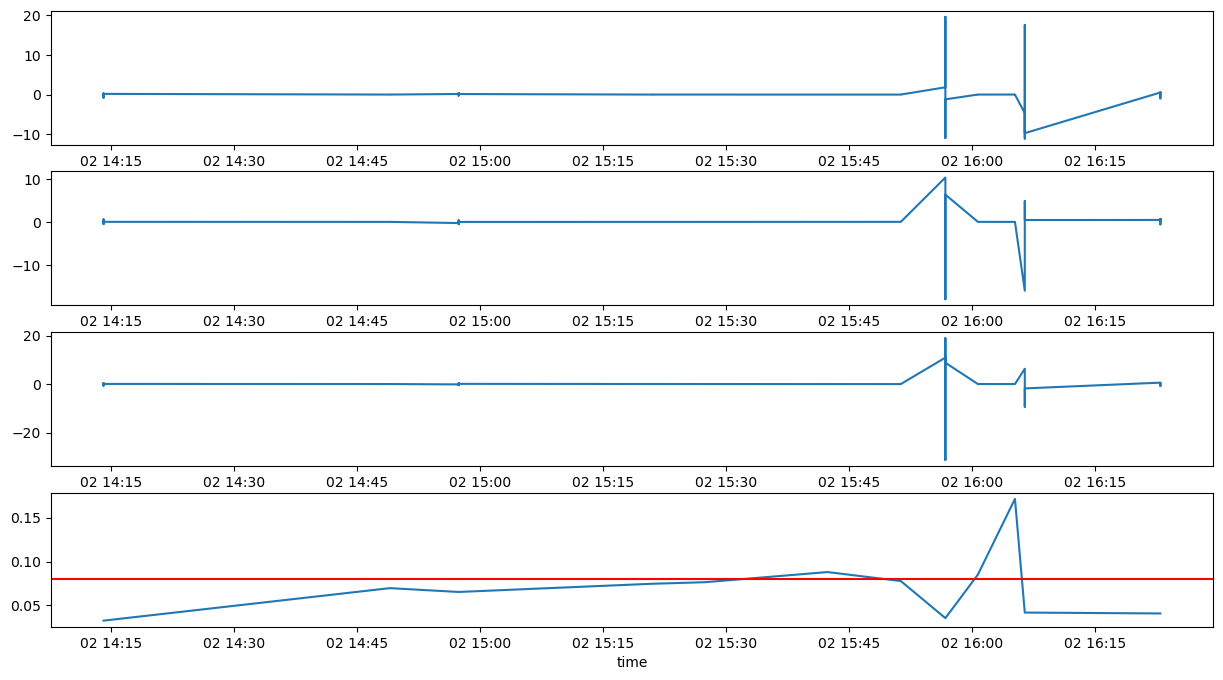

In [40]:
fig,ax = plt.subplots(4, figsize = (15,8))
plt.xlabel('time')
ax[0].plot('time','x',data = df_all)
ax[1].plot('time','y',data = df_all)
ax[2].plot('time','z',data = df_all)
ax[3].plot('time','TAC_Reading',data = df_all)
ax[3].axhline(y=0.08, color = 'r', linestyle = '-')


In [27]:
# fig,ax = plt.subplots(4, figsize = (15,8))
# plt.xlabel('time')
# ax[0].plot('time','x',data = df_normalized)
# ax[1].plot('time','y',data = df_normalized)
# ax[2].plot('time','z',data = df_normalized)
# ax[3].plot('time','TAC_Reading',data = df_normalized)



In [28]:
# Components for acceleration in x direction

# Following the convention for segment size T>=5D
segment_length_x = int(round(df_all.shape[0]/5,0))
pe_results_x = []
comp_results_x = []


for i in range(0,5):
    start_index = i*segment_length_x
    end_index = start_index + segment_length_x
    
    input_list = list(df_all['x'][start_index:end_index])
    
    op = ordinal_patterns(input_list, 3, 1)
    pe = p_entropy(op)
    comp = complexity(op)
    
    pe_results_x.append(pe)
    comp_results_x.append(comp)
    

In [29]:
df_all[['x','TAC_Reading']][0:1229]

,x,TAC_Reading
0,0.131200,0.032672
1,0.273400,0.032672
2,0.151400,0.032672
3,-0.091400,0.032672
4,-0.793500,0.032672
5,-0.342700,0.032672
6,-0.371800,0.032672
7,-0.228800,0.032672
8,-0.005300,0.032672
9,-0.106900,0.032672


In [30]:
# Printing the permutation entropy result of x

pe_results_x

[0.9582255574452221,
 0.9864227750651389,
 0.9983229134958873,
 0.9731950251479947,
 0.9438221028956725]

In [31]:
#Printing the complexity result of x

comp_results_x

[0.0405029836740981,
 0.01370088881414036,
 0.0016618078012607727,
 0.024664715400325166,
 0.051315827153278995]

In [32]:
# Components for acceleration in y direction

segment_length_y = int(round(df_all.shape[0]/5,0))
pe_results_y = []
comp_results_y = []

for i in range(0,5):
    start_index = i*segment_length_y
    end_index = start_index + segment_length_y
    
    input_list = list(df_all['y'][start_index:end_index])
    
    op = ordinal_patterns(input_list, 3, 1)
    pe = p_entropy(op)
    comp = complexity(op)
    
    pe_results_y.append(pe)
    comp_results_y.append(comp)
    

In [33]:
# Printing the permutation entropy result of y

pe_results_y

[0.918896090777148,
 0.998781522840396,
 0.9891892880257012,
 0.9559635284262776,
 0.9333038969345313]

In [34]:
# Printing the complexity result of y

comp_results_y

[0.0405029836740981,
 0.01370088881414036,
 0.0016618078012607727,
 0.024664715400325166,
 0.051315827153278995]

In [35]:
# Components for acceleration in z direction

segment_length_z = int(round(df_all.shape[0]/5,0))
pe_results_z = []
comp_results_z = []

for i in range(0,5):
    start_index = i*segment_length_z
    end_index = start_index + segment_length_z
    
    input_list = list(df_all['z'][start_index:end_index])
    
    op = ordinal_patterns(input_list, 3, 1)
    pe = p_entropy(op)
    comp = complexity(op)
    
    pe_results_z.append(pe)
    comp_results_z.append(comp)
    

In [36]:
# Printing the permutation entropy result of z

pe_results_z

[0.9905513371530683,
 0.9743882882881202,
 0.9923904985003168,
 0.9638455957044966,
 0.9746415164209047]

In [37]:
# Printing the complexity result of z

comp_results_z

[0.009171158592067637,
 0.024995969778616633,
 0.007350840210279693,
 0.035815605862475446,
 0.023935907899817404]

In [38]:
df_metrics = pd.DataFrame([pe_results_x,pe_results_y,pe_results_z,
                        comp_results_x,comp_results_y,comp_results_z
                        ]).transpose()


df_metrics = df_metrics.rename(columns = {0:'pe_results_x',
                                          1:'pe_results_y',
                                          2:'pe_results_z',
                                          3:'comp_results_x',
                                          4:'comp_results_y',
                                          5:'comp_results_z'})

df_metrics

,pe_results_x,pe_results_y,pe_results_z,comp_results_x,comp_results_y,comp_results_z
0,0.958226,0.918896,0.990551,0.040503,0.070869,0.009171
1,0.986423,0.998782,0.974388,0.013701,0.001202,0.024996
2,0.998323,0.989189,0.992390,0.001662,0.010109,0.007351
3,0.973195,0.955964,0.963846,0.024665,0.041147,0.035816
4,0.943822,0.933304,0.974642,0.051316,0.060876,0.023936


<Axes: >

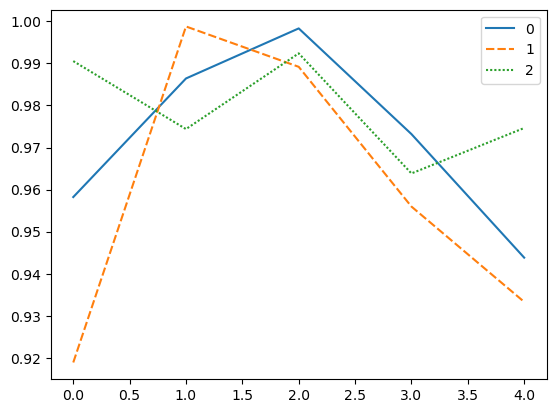

In [41]:
sns.lineplot((pe_results_x,pe_results_y,pe_results_z))

<Axes: >

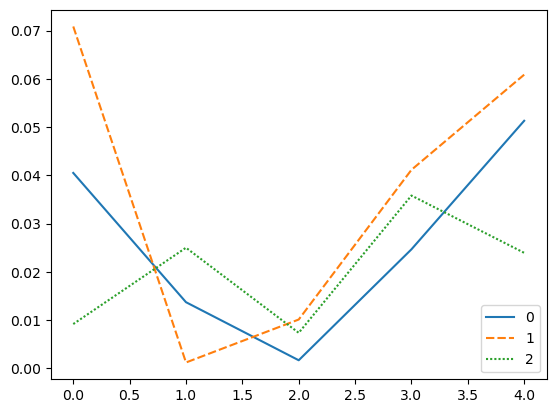

In [42]:
sns.lineplot((comp_results_x,comp_results_y,comp_results_z))

Following the above approach with permutation entropy and complexity method for all 3 components-x,y & z , We cannot see any kind of correlation betwen permutation entropy and complexity method. Therefore, permutation entropy and complexity method is not reliable in differentiating heavy drinking vs. sober cases.